# Earthquakes and Self-Organized Criticality

## Introduction

The earth's crust is made of up plates that are separated by fault lines. Over time, these plates slowly deform, and build up potential energy until they shift all at once. This is an earthquake, and it is very hard to predict exactly when it will happen. The size of an earthquake is measured using the Richter scale. It is a logarithmic scale that representing the amount one plate shifts relative to another. We use a logarithmic scale, because it there are a wide range of magnitudes, and small earthquakes are more common than large ones. The Gutenberg-Richter law states the probability of an earthquake of a certain magnitude happening:

\begin{equation*}    
P (M) = Ae^{-bM}
\end{equation*}

Where M is the magnitude. Power law distributions like this are rare, and they suggest that the earth must be at a certain critical point in density and temperature in order for earthquakes to happen. The tendency for the earth to be shifted towards this critical point as a result of the earthquake phenomena is called self-organized criticality.

To understand the basic behavior of earthquakes, we can use a model that contains a series of blocks and springs in between two plates on the top and bottom. These represent two of the earth's adjacent plates that slide past each other. The top plate moves at a steady and slow velocity, and it is connected to each block by a leaf spring. As a result, the leaf springs will slowly build up tension until a block moves causing other blocks to move. This is an earthquake. In this model, the friction force between the bottom plate and the blocks decreases as the velocity of the block increases.

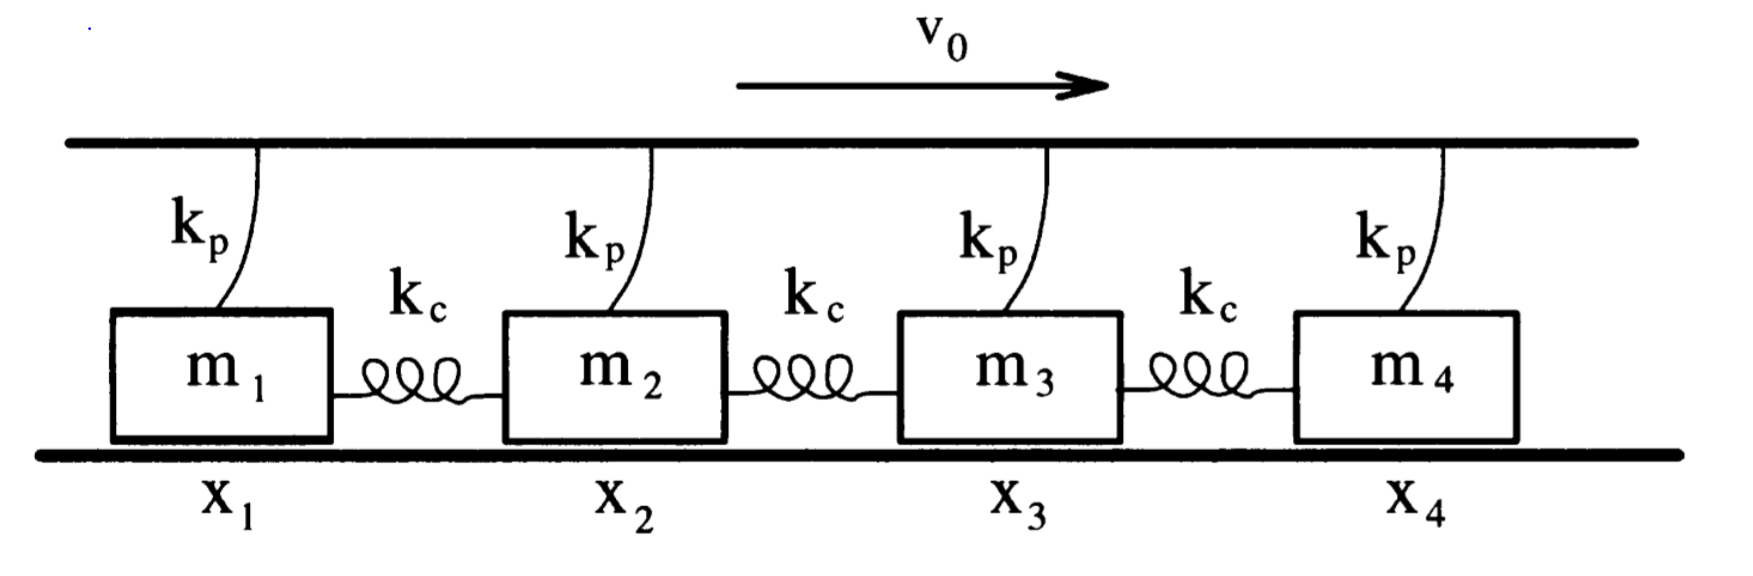


## Model

The equations that model the spring force on the blocks:  
* Spring force on block from neighboring blocks:
    
\begin{equation*}    
F_b = -k_c(x_i - x_{i+1}) - k_c(x_i - x_{i-1})
\end{equation*}

* Force of a leaf spring from the top plate on block: 

\begin{equation*}    
F_l = -k_p(x_i - v_0 t)
\end{equation*} 
    
* Friction force due to bottom plate: 

\begin{equation*}
F_f = -\frac{F_0 sin(v_i)}{1 + |v_i / v_f|}
\end{equation*}

Overall equation of motion: 

\begin{equation*}
m_i \frac{d^2 x_i}{dt^2} = k_c(x_{i+1} + x_{i-1} - 2x_i) + k_p(v_0 t - x_i) + F_f
\end{equation*}

* If we break this up, we have: 

\begin{equation*}    
\frac{dx_i}{dt} = v_i \space\space and \space\space m_i \frac{d v_i}{dt} = k_c(x_{i+1} + x_{i-1} - 2x_i) + k_p(v_0 t - x_i) + F_f
\end{equation*}

## Numerical Methods

In [1]:
import pylab as plt
import numpy as np
import random
%matplotlib inline

In [73]:
def friction (vi, vf, F0):
    """
    Returs the friction of the bottom plate against blocks moving at a specific velocity
    
    Arguements: vi - initial velovity of the block
                vf - final velocity of the block
                F0 - the static friction force
    
    Returned: The force due to friction
    
    Examples:
    
    >>> friction (0, 1, 20)
    -20.0
    
    >>> friction (1, 1, 20)
    -10.0
    """
    if vi == 0:
        sign = 1
        
    else:
        sign = vi / abs(vi)
        
    force = -((F0) * sign / (1 + abs(vi/vf)))
    return force

In [115]:
def blockMotion (t, blockPositions, vBlock, i, blockNum, kp, kc, mass, F0, v0, vf, ):
    """
    Returns the differential equation that models the motion of the blocks
    
    Arguements: kp - spring constant of leaf springs
                kc - spring constant of springs between blocks
                mass - mass of individual block
                F0 - the static friction force
                v0 - initial velocoty of top plate
                vi - the previous velocity of the block
                vf - the current velocity of the block
                x - the array containting x positions
                i - the index of the current block
                t - time
                blockNum - the number of blocks
                
    Returned: The differential equation modeling the motion of the individual blocks
    
    Examples:
    
    >>> blockMotion (0, (0,0), 2, 0, 0, 1, 2, 0, 1, 20, (0, 1, 2, 3, 4))
    array([ 0.,  0.])
    
    >>> blockMotion (200, (1,0), 2, 40, 250, 1, 50, 0.01, 1, 20, (0, 1, 2, 3, 4))
    array([ 0.,  0.])
    
    >>> blockMotion (200, (1,1), 2, 40, 250, 1, 50, 0.01, 1, 20, (0, 1, 2, 3, 4))
    array([ 0.,  0.])
    """
    xi = blockPositions[i]
    vi = vBlock
    
    if i == 1:
        xiP = blockPositions[i + 1]
        totalForce = (kc*(xiP - 1 - 2*xi) + kp * (v0 * t - xi) + friction (vi, vf, F0)) / mass
        
    elif i == blockNum:
        xiM = blockPositions[i - 1]
        totalForce = (kc*(xiM  - xi) + kp * (v0 * t - xi) + friction (vi, vf, F0)) / mass
        
    else:
        xiM = blockPositions[i - 1]
        xiP = blockPositions[i + 1]
        totalForce = (kc*(xiP + xiM - 2 * xi) + kp * (v0 * t - xi) + friction (vi, vf, F0)) / mass
    
    
    if totalForce <= 0:
        dv = -vi
        vi = 0
        dx = vi
        
    else: 
        dx = vi
        dv = totalForce
        
    return np.array([dx, dv], float)

In [112]:
def eulerCoupled (f, n, blockPositions, vBlock, blockNum, interval, steps, *args):
    """ 
    Solve a coupled system of ODEs by Euler method with fixed number of steps.

    Arguements: f - function giving ODE as y'=f(x,y)
                n - the number of ODEs
                r0 - initial value
                interval - tuple region (a,b) on which to solve ODE
                steps - number of steps
    
    Returned: An array containing the output of the two equatons and the time
    """
    
    # set up solution mesh
    # points will be indexed 0..steps
    (a,b) = interval  # endpoints
    h = (b-a)/steps  # step size
    points = np.zeros((steps + 1, blockNum*2 + 1))

    # set up initial point
    t = a    
    points[0,0] = t
    count = 0
    
    for l in range(1, blockNum + 1):
        points[0,l] = blockPositions[count]   
        count += 1
    for m in range(blockNum + 1, blockNum * 2 + 1):
        points[0,m] = vBlock
        
    print(points[0, :])

    for k in range(1,steps+1): # Repeats for each timestep                   
        t = t + h
        
        for i in range(0, blockNum): # Repeats for each block
            r = (points[k-1, i + 1], points[k-1, i + blockNum + 1]) # Updates r from previous timestep
            r_new = r + h * f(t, blockPositions, r[1], i, blockNum, *args)
            
            r = r_new
            blockPositions[i] = r[0]
            
            points[k,0] = t
            points[k,i + 1] = r[0]
            points[k,i + 1 + blockNum] = r[1]
            
        print(points[k, :])


    return points

[  0.00000000e+00  -3.16192804e-06   1.00057258e+00   1.99950344e+00
   3.00027618e+00   4.00006902e+00   4.99942280e+00   5.99932263e+00
   7.00068512e+00   7.99962735e+00   8.99927226e+00   9.99940499e+00
   1.10002358e+01   1.19992990e+01   1.29999625e+01   1.39994773e+01
   1.50001258e+01   1.60004954e+01   1.69990781e+01   1.79994307e+01
   1.89994391e+01   2.00003382e+01   2.09991377e+01   2.20008145e+01
   2.30001133e+01   2.39993374e+01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[  1.00000000e-01  -3.16192804e-06   1.00057258e+00   1.99950344e+00
   3.00027618e+00   4.00006902e+00   4.99942280e+0

[  5.3         64.49984699   1.00057258   1.99950344   3.00027618
   4.00006902   4.9994228    5.99932263   7.00068512   7.99962735
   8.99927226   9.99940499  11.00023581  11.99929896  12.99996253
  13.99947727  15.00012578  16.0004954   16.99907809  17.99943069
  18.99943909  20.00033818  20.9991377   22.00081454  23.00011333
  23.99933736   6.0067293    0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
[  5.4         64.49984699   1.00057258   1.99950344   3.00027618
   4.00006902   4.9994228    5.99932263   7.00068512   7.99962735
   8.99927226   9.99940499  11.00023581  11.99929896  12.99996253
  13.99947727  15.00012578  16.0004954   16.99907809  17.99943069
  18.99943909  20.00033818  20.9991377   22.00081454  23.00011333
  23.99933736   5.406

[  1.72000000e+01   6.44998470e+01   1.00057258e+00   1.99950344e+00
   3.00027618e+00   4.00006902e+00   4.99942280e+00   5.99932263e+00
   7.00068512e+00   7.99962735e+00   8.99927226e+00   9.99940499e+00
   1.10002358e+01   1.19992990e+01   1.29999625e+01   1.39994773e+01
   1.50001258e+01   1.60004954e+01   1.69990781e+01   1.79994307e+01
   1.89994391e+01   2.00003382e+01   2.09991377e+01   2.20008145e+01
   2.30001133e+01   2.39993374e+01   2.15524518e-05   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[  1.73000000e+01   6.44998470e+01   1.00057258e+00   1.99950344e+00
   3.00027618e+00   4.00006902e+00   4.99942280e+0

   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[  6.86000000e+01   6.44998470e+01   1.00057258e+00   1.99950344e+00
   3.00027618e+00   4.00006902e+00   4.99942280e+00   5.99932263e+00
   7.00068512e+00   7.99962735e+00   8.99927226e+00   9.99940499e+00
   1.10002358e+01   1.19992990e+01   1.29999625e+01   1.39994773e+01
   1.50001258e+01   1.60004954e+01   1.69990781e+01   1.79994307e+01
   1.89994391e+01   2.00003382e+01   2.09991377e+01   2.20008145e+01
   2.30001133e+01   2.39993374e+01   6.51848297e-29   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[  6.87000000e+01   6.44998470e+01   1.00057258e+00   1.99950344e+

   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[  1.68200000e+02   6.44998470e+01   1.00057258e+00   1.99950344e+00
   3.00027618e+00   4.00006902e+00   4.99942280e+00   5.99932263e+00
   7.00068512e+00   7.99962735e+00   8.99927226e+00   9.99940499e+00
   1.10002358e+01   1.19992990e+01   1.29999625e+01   1.39994773e+01
   1.50001258e+01   1.60004954e+01   1.69990781e+01   1.79994307e+01
   1.89994391e+01   2.00003382e+01   2.09991377e+01   2.20008145e+01
   2.30001133e+01   2.39993374e+01   1.73654458e-74   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[  1.68300000e+02   6.44998470e+01   1.00057258e+00   1.99950344e+

   0.00000000e+000   0.00000000e+000   0.00000000e+000]
[  2.65500000e+002   6.44998470e+001   1.00057258e+000   1.99950344e+000
   3.00027618e+000   4.00006902e+000   4.99942280e+000   5.99932263e+000
   7.00068512e+000   7.99962735e+000   8.99927226e+000   9.99940499e+000
   1.10002358e+001   1.19992990e+001   1.29999625e+001   1.39994773e+001
   1.50001258e+001   1.60004954e+001   1.69990781e+001   1.79994307e+001
   1.89994391e+001   2.00003382e+001   2.09991377e+001   2.20008145e+001
   2.30001133e+001   2.39993374e+001   5.21972498e-119   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000]
[  2.6560000

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Text(0.5,1,'Velocity of Block Over Time')

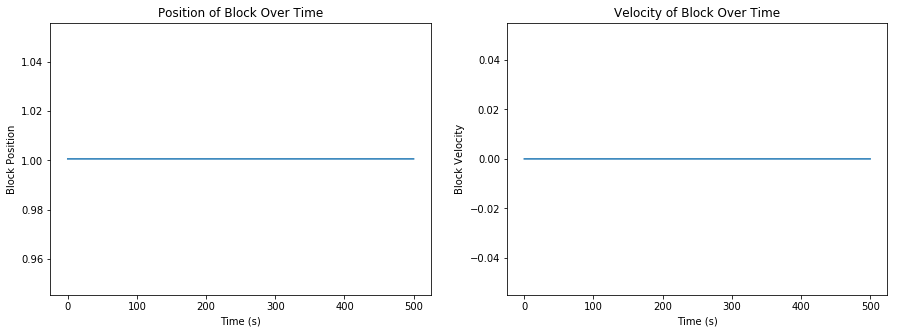

In [117]:
averageSpacing = 1
variation = 0.001
blockPositions = []
timeInterval = (0,500)
kp = 40
kc = 250
mass = 1
F0 = 50
v0 = 0.01
vf = 0.01
blockNum = 25
i = 2
vBlock = 0
timeSteps = 5000

for n in range(0, blockNum + 1):
    blockPositions.append(n * averageSpacing + (random.random() - 0.5) * 2 * variation)

earthquake = eulerCoupled (blockMotion, 2, blockPositions, vBlock, blockNum, timeInterval, timeSteps,\
                            kp, kc, mass, F0, v0, vf)

plt.figure(figsize = (15,5))

plt.subplot(121)
plt.plot(earthquake[:,0], earthquake[:, 2])
plt.xlabel("Time (s)")
plt.ylabel("Block Position")
plt.title("Position of Block Over Time")

plt.subplot(122)
plt.plot(earthquake[:,0], earthquake[:, blockNum + 2])
plt.xlabel("Time (s)")
plt.ylabel("Block Velocity")
plt.title("Velocity of Block Over Time")

In [100]:
if __name__ == "__main__":
    import doctest
    doctest.testmod()

**********************************************************************
File "__main__", line 21, in __main__.blockMotion
Failed example:
    blockMotion (0, (0,0), 2, 0, 0, 1, 2, 0, 1, 20, (0, 1, 2, 3, 4))
Exception raised:
    Traceback (most recent call last):
      File "C:\Users\adria\Anaconda3\lib\doctest.py", line 1330, in __run
        compileflags, 1), test.globs)
      File "<doctest __main__.blockMotion[0]>", line 1, in <module>
        blockMotion (0, (0,0), 2, 0, 0, 1, 2, 0, 1, 20, (0, 1, 2, 3, 4))
      File "<ipython-input-99-33e61eb3d413>", line 39, in blockMotion
        totalForce = (kc*(xiM  - xi) + kp * (v0 * t - xi) + friction (vi, vf, F0)) / mass
      File "<ipython-input-73-a7868c88f363>", line 25, in friction
        force = -((F0) * sign / (1 + abs(vi/vf)))
    TypeError: unsupported operand type(s) for /: 'int' and 'tuple'
**********************************************************************
File "__main__", line 24, in __main__.blockMotion
Failed example:
  